# 02. データ前処理と特徴量エンジニアリング (Preprocessing and Feature Engineering)

## 概要
生のデータを機械学習モデルが扱える形式に変換する方法を学びます。

## 学習目標
- データのスケーリングと正規化ができる
- 欠損値を適切に処理できる
- カテゴリカル変数をエンコードできる
- 新しい特徴量を作成できる
- 次元削減の手法を理解できる

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, 
    LabelEncoder, OneHotEncoder, OrdinalEncoder
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

## 1. データスケーリング

### なぜスケーリングが必要か？

機械学習アルゴリズムの多くは、特徴量のスケールに敏感です。

**スケーリングが重要な理由:**
- ニューラルネットワーク: 学習の収束速度に影響
- SVM: 距離ベースの計算に影響
- k-NN: ユークリッド距離の計算に影響
- PCA: 分散が大きい特徴量に偏る

### 主なスケーリング手法

1. **StandardScaler（標準化）**
   - 平均0、標準偏差1に変換
   - 式: z = (x - μ) / σ
   - 最もよく使われる

2. **MinMaxScaler（正規化）**
   - 0〜1の範囲に変換
   - 式: x' = (x - min) / (max - min)
   - 外れ値に敏感

3. **RobustScaler（ロバスト標準化）**
   - 中央値と四分位範囲を使用
   - 外れ値に頑健

In [2]:
# サンプルデータ生成
np.random.seed(42)
data = {
    'age': np.random.randint(20, 70, 100),
    'salary': np.random.randint(30000, 150000, 100),
    'score': np.random.uniform(0, 100, 100)
}
df = pd.DataFrame(data)

# 外れ値を追加
df.loc[0, 'salary'] = 500000
df.loc[1, 'age'] = 95

print("元のデータの統計:")
print(df.describe())

元のデータの統計:
              age         salary       score
count  100.000000     100.000000  100.000000
mean    44.540000   95165.990000   51.525985
std     15.315154   53851.241748   27.922839
min     20.000000   30206.000000    0.052038
25%     33.000000   59376.500000   26.875450
50%     43.000000   92607.500000   50.850643
75%     58.000000  119596.750000   72.450897
max     95.000000  500000.000000   99.774049


/tmp/ipykernel_4510/3392922152.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_scaled, labels=df.columns)
/tmp/ipykernel_4510/3392922152.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_scaled, labels=df.columns)
/tmp/ipykernel_4510/3392922152.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_scaled, labels=df.columns)
/tmp/ipykernel_4510/3392922152.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxp

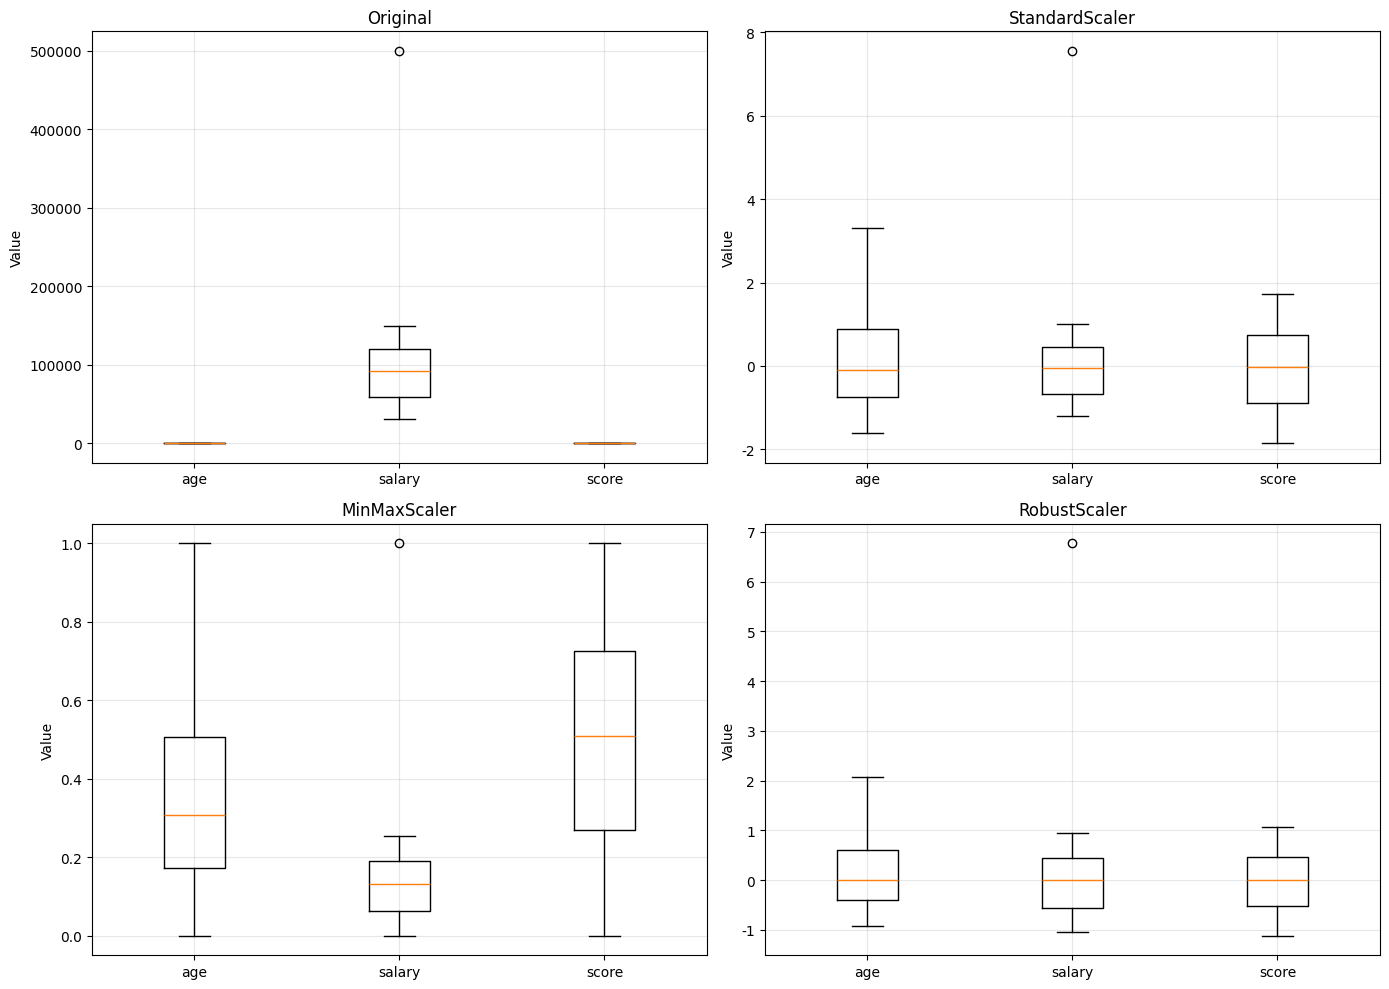

In [3]:
# 3つのスケーリング手法を比較
scalers = {
    'Original': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, scaler) in enumerate(scalers.items()):
    if scaler is None:
        data_scaled = df.values
    else:
        data_scaled = scaler.fit_transform(df.values)
    
    # 箱ひげ図
    axes[idx].boxplot(data_scaled, labels=df.columns)
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### スケーリングの注意点

**重要: データリークを防ぐ**

```python
# ❌ 間違い: 全データでfit
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test = train_test_split(X_scaled)

# ✅ 正しい: 訓練データのみでfit
X_train, X_test = train_test_split(X)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fitしない！
```

## 2. 欠損値の処理

### 欠損値とは

データが記録されていない、または利用できない状態です。

**欠損値の原因:**
- データ収集時のエラー
- センサーの故障
- 回答者が質問をスキップ
- データ統合時の不一致

### 欠損値の処理方法

1. **削除**
   - 欠損が少ない場合
   - データ量が十分にある場合

2. **補完（Imputation）**
   - 平均値/中央値/最頻値
   - k-NN補完
   - 予測モデルでの補完

欠損値の状況:
A    2
B    2
C    2
dtype: int64

欠損率: 20.0%


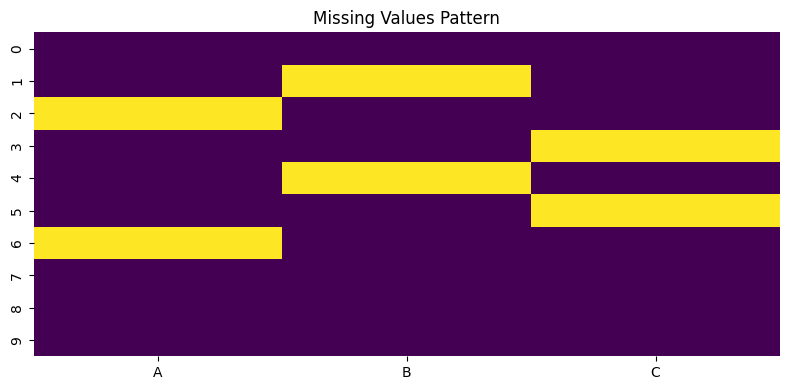

In [4]:
# 欠損値を含むデータ生成
np.random.seed(42)
df_missing = pd.DataFrame({
    'A': [1, 2, np.nan, 4, 5, 6, np.nan, 8, 9, 10],
    'B': [10, np.nan, 30, 40, np.nan, 60, 70, 80, 90, 100],
    'C': [100, 200, 300, np.nan, 500, np.nan, 700, 800, 900, 1000]
})

print("欠損値の状況:")
print(df_missing.isnull().sum())
print(f"\n欠損率: {df_missing.isnull().sum().sum() / df_missing.size * 100:.1f}%")

# 可視化
plt.figure(figsize=(8, 4))
sns.heatmap(df_missing.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Pattern')
plt.tight_layout()
plt.show()

In [5]:
# 様々な補完方法の比較
# 平均値補完
imputer_mean = SimpleImputer(strategy='mean')
df_mean = pd.DataFrame(
    imputer_mean.fit_transform(df_missing),
    columns=df_missing.columns
)

# 中央値補完
imputer_median = SimpleImputer(strategy='median')
df_median = pd.DataFrame(
    imputer_median.fit_transform(df_missing),
    columns=df_missing.columns
)

# k-NN補完
imputer_knn = KNNImputer(n_neighbors=3)
df_knn = pd.DataFrame(
    imputer_knn.fit_transform(df_missing),
    columns=df_missing.columns
)

# 比較
print("列Aの欠損値（元: NaN）:")
print(f"  平均値補完: {df_mean.loc[2, 'A']:.2f}")
print(f"  中央値補完: {df_median.loc[2, 'A']:.2f}")
print(f"  k-NN補完: {df_knn.loc[2, 'A']:.2f}")

列Aの欠損値（元: NaN）:
  平均値補完: 5.62
  中央値補完: 5.50
  k-NN補完: 4.00


## 3. カテゴリカル変数のエンコーディング

### カテゴリカル変数とは

数値ではなく、カテゴリー（ラベル）で表現される変数です。

**例:**
- 名義変数: 色（赤、青、緑）、性別（男、女）
- 順序変数: 評価（低、中、高）、学年（1年、2年、3年）

### エンコーディング手法

1. **Label Encoding**
   - 各カテゴリーに整数を割り当て
   - 順序変数に適している
   - 順序関係のない変数には不適切

2. **One-Hot Encoding**
   - 各カテゴリーを二値変数に変換
   - 名義変数に適している
   - 次元数が増加

In [6]:
# カテゴリカルデータのサンプル
df_cat = pd.DataFrame({
    'color': ['red', 'blue', 'green', 'red', 'blue', 'green'],
    'size': ['S', 'M', 'L', 'M', 'S', 'L'],
    'grade': ['A', 'B', 'C', 'A', 'B', 'C']
})

print("元のデータ:")
print(df_cat)

# Label Encoding
le = LabelEncoder()
df_label = df_cat.copy()
df_label['color_encoded'] = le.fit_transform(df_cat['color'])

print("\nLabel Encoding:")
print(df_label[['color', 'color_encoded']])

# One-Hot Encoding
df_onehot = pd.get_dummies(df_cat, columns=['color'], prefix='color')

print("\nOne-Hot Encoding:")
print(df_onehot)

元のデータ:
   color size grade
0    red    S     A
1   blue    M     B
2  green    L     C
3    red    M     A
4   blue    S     B
5  green    L     C

Label Encoding:
   color  color_encoded
0    red              2
1   blue              0
2  green              1
3    red              2
4   blue              0
5  green              1

One-Hot Encoding:
  size grade  color_blue  color_green  color_red
0    S     A       False        False       True
1    M     B        True        False      False
2    L     C       False         True      False
3    M     A       False        False       True
4    S     B        True        False      False
5    L     C       False         True      False


## 4. 特徴量エンジニアリング

### 特徴量エンジニアリングとは

既存の特徴量から新しい特徴量を作成し、モデルの性能を向上させる技術です。

### 一般的な手法

1. **多項式特徴量**
   - x² や x₁×x₂ などの項を追加
   - 非線形関係を捉える

2. **ビニング（離散化）**
   - 連続値を区間に分割
   - 例: 年齢 → 若年層/中年層/高年層

3. **集約統計量**
   - グループごとの平均、合計、最大値など

4. **時間特徴量**
   - 日付から年、月、曜日などを抽出

In [7]:
from sklearn.preprocessing import PolynomialFeatures

# 多項式特徴量の生成
X_simple = np.array([[1, 2], [3, 4], [5, 6]])

print("元の特徴量:")
print(X_simple)
print(f"形状: {X_simple.shape}")

# 2次の多項式特徴量を生成
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_simple)

print("\n多項式特徴量（2次）:")
print(X_poly)
print(f"形状: {X_poly.shape}")
print(f"\n特徴量名: {poly.get_feature_names_out(['x1', 'x2'])}")

元の特徴量:
[[1 2]
 [3 4]
 [5 6]]
形状: (3, 2)

多項式特徴量（2次）:
[[ 1.  2.  1.  2.  4.]
 [ 3.  4.  9. 12. 16.]
 [ 5.  6. 25. 30. 36.]]
形状: (3, 5)

特徴量名: ['x1' 'x2' 'x1^2' 'x1 x2' 'x2^2']


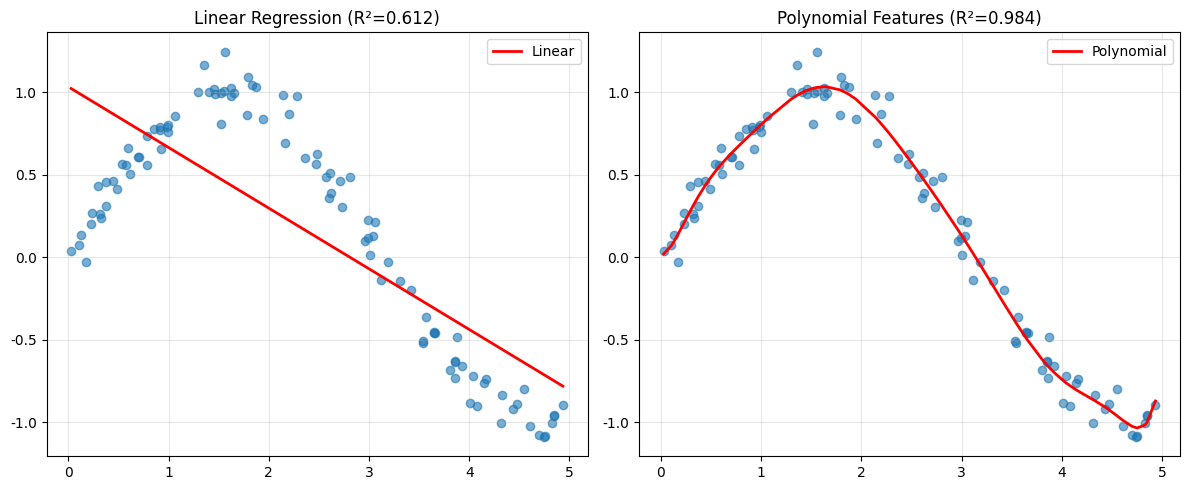

In [8]:
# 実際の効果を確認
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 非線形データ生成
np.random.seed(42)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.randn(100) * 0.1

# 線形回帰（通常）
lr_simple = LinearRegression()
lr_simple.fit(X, y)
y_pred_simple = lr_simple.predict(X)
r2_simple = r2_score(y, y_pred_simple)

# 線形回帰（多項式特徴量付き）
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X)
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y)
y_pred_poly = lr_poly.predict(X_poly)
r2_poly = r2_score(y, y_pred_poly)

# 可視化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred_simple, 'r-', linewidth=2, label='Linear')
plt.title(f'Linear Regression (R²={r2_simple:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred_poly, 'r-', linewidth=2, label='Polynomial')
plt.title(f'Polynomial Features (R²={r2_poly:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 次元削減

### 次元の呪い

特徴量が多すぎると:
- 計算コストが増大
- 過学習のリスクが増加
- データが疎になる

### 次元削減の手法

1. **特徴選択（Feature Selection）**
   - 重要な特徴量のみを選択
   - 解釈性が保たれる

2. **特徴抽出（Feature Extraction）**
   - 新しい特徴量の組み合わせを作成
   - PCA、t-SNEなど

元のデータ形状: (150, 4)
削減後のデータ形状: (150, 2)

累積寄与率: 0.978
各主成分の寄与率: [0.92461872 0.05306648]


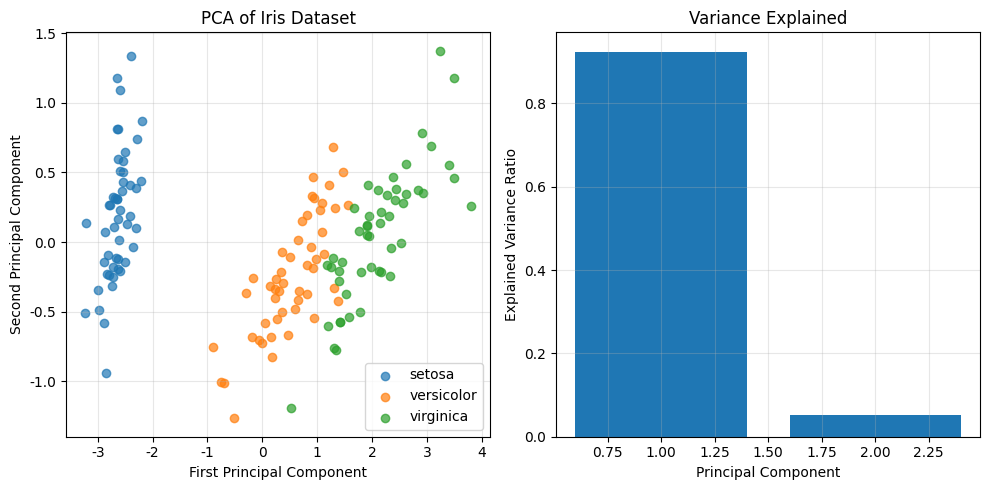

In [9]:
# PCAによる次元削減
from sklearn.datasets import load_iris

# Irisデータセット読み込み
iris = load_iris()
X = iris.data
y = iris.target

print(f"元のデータ形状: {X.shape}")

# PCAで2次元に削減
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(f"削減後のデータ形状: {X_pca.shape}")
print(f"\n累積寄与率: {pca.explained_variance_ratio_.sum():.3f}")
print(f"各主成分の寄与率: {pca.explained_variance_ratio_}")

# 可視化
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for i, target_name in enumerate(iris.target_names):
    plt.scatter(X_pca[y==i, 0], X_pca[y==i, 1], label=target_name, alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Iris Dataset')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, 3), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 完全な前処理パイプライン

### 実践例

実際のワークフローで前処理をどのように組み込むかを示します。

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# データ生成
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    random_state=42
)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# パイプライン構築
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# クロスバリデーション
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 学習と評価
pipeline.fit(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Test Accuracy: {test_score:.4f}")

CV Accuracy: 0.8425 (+/- 0.0092)


Test Accuracy: 0.8400


## 7. まとめ

### 本ノートブックで学んだこと

1. **データスケーリング**
   - StandardScaler、MinMaxScaler、RobustScaler
   - データリークの防止

2. **欠損値の処理**
   - 削除 vs 補完
   - 平均値、中央値、k-NN補完

3. **カテゴリカルエンコーディング**
   - Label Encoding
   - One-Hot Encoding

4. **特徴量エンジニアリング**
   - 多項式特徴量
   - 新しい特徴量の作成

5. **次元削減**
   - PCA
   - 特徴選択

6. **パイプライン**
   - 前処理とモデルの統合

### 次のステップ

- Notebook 03でモデルの評価方法を学ぶ
- 実際のデータセットで前処理を実践
- より高度な特徴量エンジニアリング手法を探求